# Chapter 6

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

#### Code 6.1

In [3]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

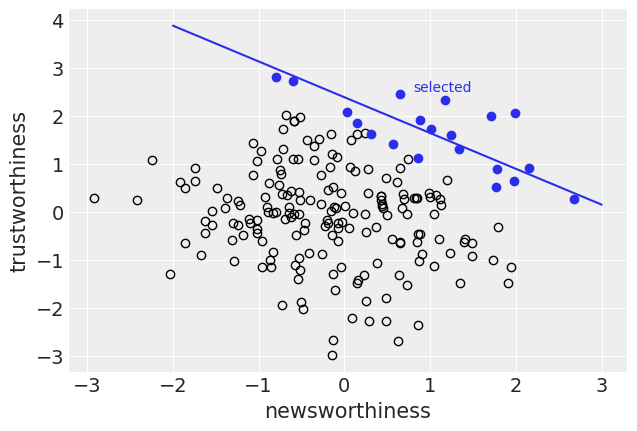

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

#### Code 6.2

In [5]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


#### Code 6.3

In [6]:
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)

    mu = a + bl * d.leg_left + br * d.leg_right
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    m_6_1_trace = pm.sample()
    idata_6_1 = az.from_pymc3(m_6_1_trace)  # create an arviz InferenceData object from the trace.
    # this happens automatically when calling az.summary, but as we'll be using this trace multiple
    # times below it's more efficient to do the conversion once at the start.

az.summary(idata_6_1, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [01:02<00:00, 32.23draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.00,0.35,0.44,1.54,0.02,0.01,515.72,477.13,517.24,471.42,1.00
bl,-1.93,2.23,-5.37,1.42,0.12,0.10,322.99,270.17,332.75,417.29,1.01
br,3.95,2.22,0.51,7.24,0.12,0.09,326.66,282.38,335.51,417.29,1.01
sigma,0.64,0.05,0.58,0.72,0.00,0.00,593.62,591.63,611.71,507.47,1.00


#### Code 6.4

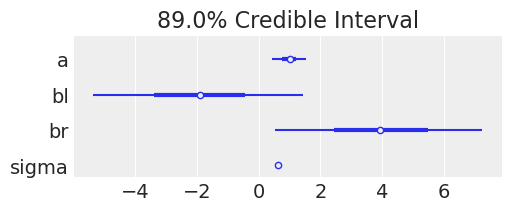

In [7]:
_ = az.plot_forest(m_6_1_trace, var_names=["~mu"], combined=True, figsize=[5, 2])

#### Code 6.5 & 6.6

Because we used MCMC (c.f. `quap`), the posterior samples are already in `m_6_1_trace`.

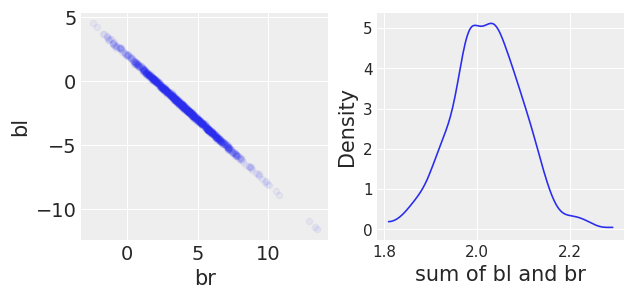

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

# code 6.5
ax1.scatter(m_6_1_trace[br], m_6_1_trace[bl], alpha=0.05, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

# code 6.6
az.plot_kde(m_6_1_trace[br] + m_6_1_trace[bl], ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bl and br");

#### Code 6.7

In [9]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    m_6_2_trace = pm.sample()
    idata_m_6_2 = az.from_pymc3(m_6_2_trace)

az.summary(idata_m_6_2, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 766.84draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.91,0.33,0.37,1.39,0.02,0.01,359.96,345.28,362.27,350.95,1.0
bl,2.04,0.07,1.93,2.15,0.00,0.00,354.44,354.44,357.83,326.12,1.0
sigma,0.65,0.05,0.58,0.72,0.00,0.00,402.18,402.18,400.74,402.59,1.0


#### Code 6.8

In [10]:
d = pd.read_csv("Data/milk.csv", sep=";")


def standardise(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


d.loc[:, "K"] = standardise(d["kcal.per.g"])
d.loc[:, "F"] = standardise(d["perc.fat"])
d.loc[:, "L"] = standardise(d["perc.lactose"])

d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


#### Code 6.9

In [11]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)

    mu = a + bF * d.F
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K)

    m_6_3_trace = pm.sample()
    idata_m_6_3 = az.from_pymc3(m_6_3_trace)

az.summary(idata_m_6_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 944.84draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.09,-0.13,0.14,0.0,0.0,1094.73,423.97,1116.99,616.26,1.0
bF,0.85,0.10,0.70,1.00,0.0,0.0,991.70,991.70,1045.93,574.30,1.0
sigma,0.49,0.07,0.37,0.60,0.0,0.0,740.10,683.96,903.64,613.10,1.0


In [12]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bF", 0, 0.5)

    mu = a + bL * d.L
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K)

    m_6_4_trace = pm.sample()
    idata_m_6_4 = az.from_pymc3(m_6_4_trace)

az.summary(idata_m_6_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1843.00draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.11,0.12,0.0,0.0,884.91,623.61,888.93,539.18,1.0
bF,-0.90,0.07,-1.03,-0.79,0.0,0.0,916.91,916.91,926.61,717.42,1.0
sigma,0.41,0.06,0.33,0.50,0.0,0.0,1041.01,1020.47,1038.45,599.73,1.0


#### Code 6.10

In [13]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F + bL * d.L
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K)

    m_6_5_trace = pm.sample()
    idata_m_6_5 = az.from_pymc3(m_6_5_trace)

az.summary(idata_m_6_5, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, bF, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 927.51draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.07,-0.12,0.11,0.00,0.00,682.65,403.23,661.23,644.40,1.00
bF,0.24,0.21,-0.11,0.56,0.01,0.01,392.26,392.26,388.51,344.29,1.01
bL,-0.67,0.21,-0.98,-0.32,0.01,0.01,401.24,380.60,397.99,368.79,1.01
sigma,0.42,0.07,0.32,0.51,0.00,0.00,408.13,408.13,363.68,271.60,1.01


#### Code 6.11

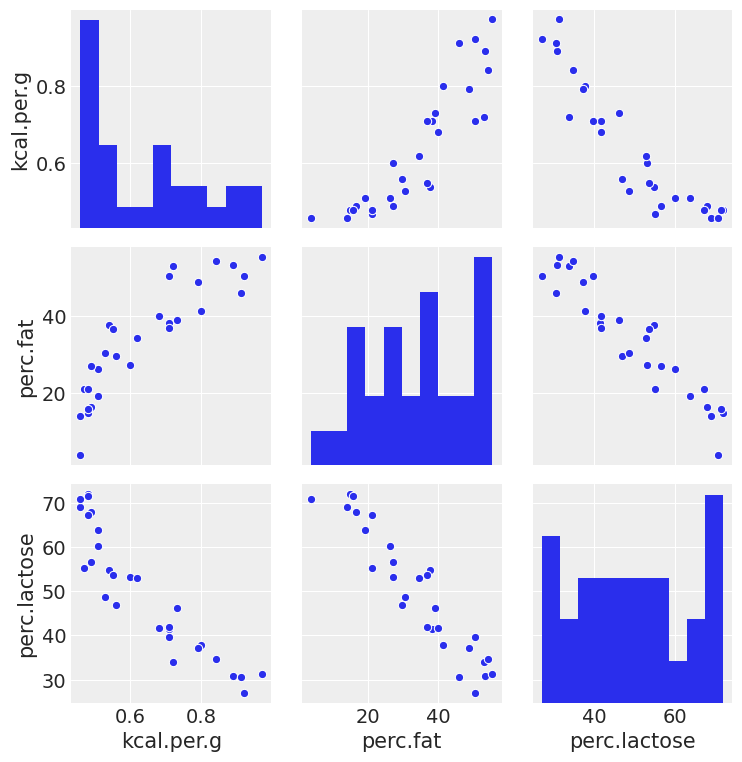

In [14]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

#### Code 6.12

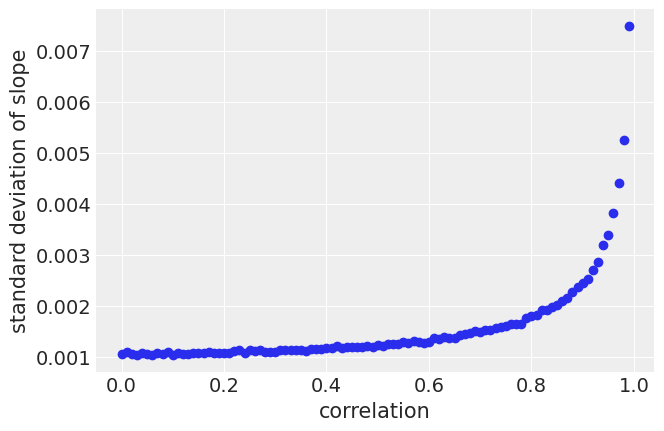

In [15]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r ** 2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

#### Code 6.13

In [16]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
h0,10.03,1.87,7.14,12.90
h1,14.25,2.43,10.42,17.64
treatment,0.50,0.50,0.00,1.00
fungus,0.26,0.44,0.00,1.00


#### Code 6.14

In [17]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
x,1.03,0.26,0.61,1.41


#### Code 6.15

In [18]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_6_trace = pm.sample()

az.summary(m_6_6_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2025.34draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.40,0.02,1.37,1.43,0.0,0.0,1014.18,1014.18,1010.46,593.79,1.01
sigma,1.87,0.13,1.66,2.08,0.0,0.0,1026.20,1020.27,1020.73,747.20,1.00


#### Code 6.16

In [19]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment + bf * d.fungus

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_7_trace = pm.sample()

az.summary(m_6_7_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1125.58draws/s]
The acceptance probability does not match the target. It is 0.8936683270553085, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.47,0.02,1.44,1.51,0.0,0.0,630.31,623.84,636.15,757.03,1.00
bt,0.02,0.03,-0.02,0.06,0.0,0.0,610.07,573.13,606.64,606.93,1.01
bf,-0.30,0.03,-0.34,-0.25,0.0,0.0,764.11,762.94,765.05,811.10,1.00
sigma,1.26,0.09,1.11,1.38,0.0,0.0,662.19,659.39,664.22,607.08,1.00


#### Code 6.17

In [20]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment

    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    m_6_8_trace = pm.sample()

az.summary(m_6_8_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1494.36draws/s]
The acceptance probability does not match the target. It is 0.8808811481735465, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.34,0.02,1.30,1.38,0.00,0.0,653.33,652.72,655.04,573.22,1.0
bt,0.11,0.04,0.05,0.17,0.00,0.0,641.23,641.23,655.13,819.42,1.0
sigma,1.85,0.13,1.63,2.03,0.01,0.0,585.12,584.99,586.02,580.31,1.0


#### Code 6.18

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

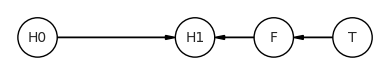

In [21]:
import daft

from causalgraphicalmodels import CausalGraphicalModel

plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [22]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('T', 'H1', {'F'})
('T', 'H0', set())
('H0', 'F', set())


#### Code 6.20

In [23]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)  # assumed probability 0.5 here, as not given in book
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
h0,10.09,1.92,7.11,13.13
h1,16.63,2.68,12.62,21.06
treatment,0.50,0.50,0.00,1.00
fungus,0.49,0.50,0.00,1.00


Re-run m_6_6 and m_6_7 on this dataset

#### Code 6.21

Including a python implementation of the sim_happiness function

In [24]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [25]:
popn = sim_happiness()

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


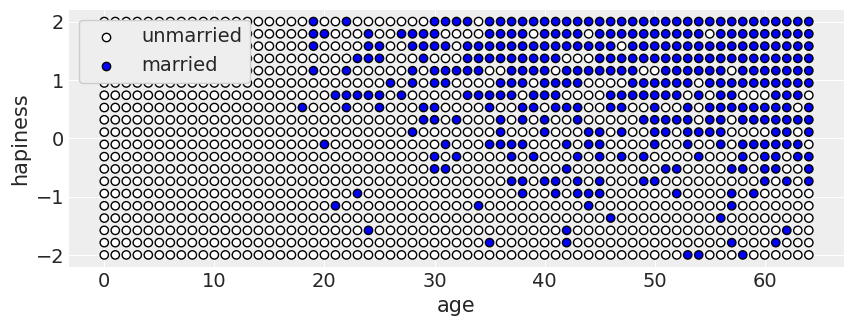

In [26]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

#### Code 6.22

In [27]:
adults = popn.loc[popn.age > 17]
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Code 6.23

In [28]:
mid = pd.Categorical(adults.loc[:, "married"].astype(int))

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    m_6_9_trace = pm.sample(1000)

az.summary(m_6_9_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 811.62draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.20,0.07,-0.31,-0.08,0.0,0.0,840.45,840.45,838.35,969.67,1.0
a[1],1.21,0.09,1.06,1.35,0.0,0.0,801.04,790.76,801.75,859.65,1.0
bA,-0.71,0.13,-0.92,-0.51,0.0,0.0,749.26,746.37,743.83,908.72,1.0
sigma,1.02,0.02,0.99,1.06,0.0,0.0,1101.92,1100.92,1103.03,1147.43,1.0


#### Code 6.24

In [29]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    trace_6_10 = pm.sample(1000)

az.summary(trace_6_10, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1397.67draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.13,0.12,0.0,0.0,887.77,671.60,887.38,800.41,1.01
bA,0.00,0.14,-0.22,0.20,0.0,0.0,894.41,655.86,902.60,873.39,1.00
sigma,1.22,0.03,1.17,1.26,0.0,0.0,1018.87,1017.38,1023.32,1002.09,1.00


#### Code 6.25

In [30]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [31]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

Text(0, 0.5, 'grandchild education (C)')

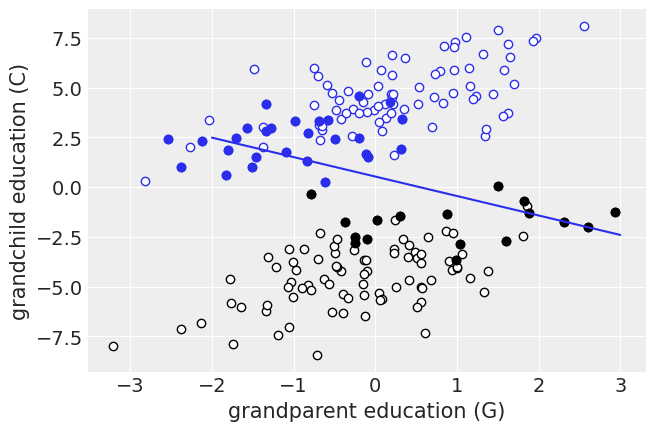

In [32]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")

#### Code 6.27

In [33]:
with pm.Model() as m_6_11:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)

    mu = a + p_PC * d.P + p_GC * d.G
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C)

    m_6_11_trace = pm.sample()

az.summary(m_6_11_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_GC, b_PC, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1373.03draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.03,0.10,-0.19,0.11,0.0,0.0,1232.56,590.38,1221.20,724.06,1.00
b_PC,1.85,0.04,1.78,1.92,0.0,0.0,924.92,924.92,932.17,715.67,1.02
b_GC,-0.81,0.10,-0.96,-0.65,0.0,0.0,917.47,916.40,924.36,784.56,1.01
sigma,1.35,0.07,1.24,1.46,0.0,0.0,944.97,931.69,974.29,762.47,1.00


#### Code 6.28

In [34]:
with pm.Model() as m_6_12:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    p_U = pm.Normal("b_U", 0, 1)

    mu = a + p_PC * d.P + p_GC * d.G + p_U * d.U
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C)

    m_6_12_trace = pm.sample()

az.summary(m_6_12_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_U, b_GC, b_PC, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 713.85draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.01,0.07,-0.12,0.10,0.00,0.00,696.77,487.20,684.98,594.45,1.0
b_PC,1.04,0.07,0.93,1.16,0.00,0.00,286.12,284.52,287.14,465.95,1.0
b_GC,-0.01,0.10,-0.16,0.16,0.01,0.00,336.21,336.21,337.39,567.53,1.0
b_U,2.01,0.16,1.76,2.26,0.01,0.01,296.52,296.52,298.34,455.46,1.0
sigma,1.00,0.05,0.93,1.08,0.00,0.00,741.49,741.49,733.05,679.65,1.0


#### Code 6.29

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [35]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


#### Code 6.30

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [36]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'M', 'A'})


#### Code 6.31

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [37]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('W', 'M', {'S'})
('W', 'A', {'S'})
('S', 'D', {'W', 'M', 'A'})


In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.10.1
numpy   1.18.1
arviz   0.7.0
pandas  1.0.3
daft    0.1.0
pymc3   3.8
last updated: Sun May 10 2020 

CPython 3.7.6
IPython 7.13.0
watermark 2.0.2
